<a href="https://colab.research.google.com/github/christianhechmann-econ2021/MastersThesis/blob/main/RL_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro - Portfolio/Asset Allocation using Deep Reinforcement Learning

See blog post: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-portfolio-allocation-9b417660c7cd

Assumptions of the financial setup for Reinforcement Learning: no margin, no short sale and no treasurity bill (risk-free asset) - we allocate all capital in assets. This corresponds to the weights sum to unity and no weights are negative (short sales). We apply monthly date with a montly rebalancing of the portfolio. The automated asset allocation strategy is based on the assumption that we treat the trading process as a Markov Decision Process where we formally define/formulate the goal of the asset allocation process to be maximization problem.\\

The components of the Reinforcement Learning setup are:
- Action - The portfolio weights of the individual securities. Must be in [0,1]. As applied in (REF TO PAPER), then we apply a softmax function in order to normalize the weights to sum to unity.
- State - gives the information of the financial state. In the example the state is defined in terms of {Covariance Matrix, MACD, RSI, CCI ADX} where it furthermore has the dimension (34, 30). The Covariance matrix is added as a feature for the state space as it quantifies the risk (standard deviation) of the portfolio.
- Reward function - r(s,a,s') = $p_t$, where $p_t$ is the cumulative portfolio value
- Environment: portfolio allocation for cross asset

In the following we extract some data:

# Install Packages

In [1]:
# Install Yahoo Finance, stockstats and stable_baselines
!pip install yfinance
!pip install stockstats
!pip install stable_baselines3
!pip install git+https://github.com/quantopian/pyfolio

     |████████████████████████████████| 5.5MB 8.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=c65279d3b9be3480c1063abeb428cebfae5e455636ff8563b658e9cdc81c4cdb
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 153kB 11.1MB/s 
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-lifq0nhy
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-lifq0nhy
     |████████████████████████████████| 61kB 5.3MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75764 sha256=9f66b1fcf73c6227e00e3f3a80a488d0367af27e2c81d0893081568cc1199715
  Stored in directory: /tmp/pip-ephem-wheel-cache-7_brlq4x/wheels/62/7d/a7/3e462442ba7d

# Import libraries

In [2]:
# yfinance syntax: https://towardsdatascience.com/best-5-free-stock-market-apis-in-2019-ad91dddec984

import yfinance as yf
import pandas_datareader.data as pdata # Useful for FF data lib or FRED database
import datetime as dt
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
import stockstats
from stockstats import StockDataFrame as Sdf
import gym
from gym.utils import seeding
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pyfolio
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3 import SAC
from scipy import stats
import pandas_datareader.data as pdata

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


# Classes and functions for data extraction

In [ ]:
# --------------------------------------------------------#
### Run the cell to define the data extraction function ###
# --------------------------------------------------------#

# Help functions for the API
'''
dir(yf)
help(yf)
'''

def extract_data(start_date, end_date, tickers, horisontal = False):
  data = []
  for ticker in tickers:
    temp = yf.download(ticker, start_date, end_date)
    temp = pd.DataFrame(temp)
    temp['tic'] = str(ticker) 
    data.append(temp)
    temp = None

  # Merge the data
  df = pd.concat(data, axis=0)
  df.reset_index(level=0, inplace=True)
  # Adjust date column 
  df['Date'] =df.Date.apply(lambda x: x.strftime("%Y-%m-%d"))
  # Sort dates 
  df = df.sort_values(['Date', 'tic'], ignore_index=True)

  # Set the Close = Adj Close and drop the Adj Close column
  df['Close'] = df['Adj Close']
  df.drop('Adj Close', axis = 1, inplace=True)

  if horisontal:
    df = df.pivot_table(index = 'Date', columns='tic', values = 'Close')
    #pd.MultiIndex.from_product([[str(ticker)], temp.columns])



  # Print shape
  #print( '----------------------------------------')
  #print('The shape of the dataframe is {}'.format(df.shape))
  #print( '----------------------------------------')

  # Return df
  return df


In [ ]:
# Implementing similar custom class for preprocessing data

class features:
  '''
  Code implemented with inspiration from https://github.com/AI4Finance-LLC/FinRL-Library/blob/master/finrl/preprocessing/preprocessors.py

  Methods:
  -----------
  add_technical_features()
    Function to implement technical features to the df given as input

  '''

  def __init__(self, indicator_list):
    self = self 
    self.indicator_list = None



  def preprocess_data(self, data, indicator_list):
    '''
    Function to calculate and implement technical features to the df given as input
    The function calculates the technical indicators using the 'stockstats' python package
    as well as own computations (not implemented yet) 

    Input: pandas dataframe with financial assets
    Returns: pandas dataframe with technical indicators
    '''
    self.indicator_list = indicator_list
    self.data = data

    # Import relevant libraries
    from stockstats import StockDataFrame as sdf

    df = self.data.copy()
    df_sdf = sdf.retype(df.copy())
    tickers = df_sdf.tic.unique()

    for indicator in self.indicator_list:
      # Create empty dataframe for storing temp indicator computations
      df_indicator = pd.DataFrame()

      for i in range(len(tickers)):
        try:
          indicator_temp = df_sdf[df_sdf.tic == tickers[i]][indicator] # Compute indicator
          indicator_temp = pd.DataFrame(indicator_temp) # Transform back to normal pandas dataframe
          df_indicator = df_indicator.append(indicator_temp, ignore_index = True)

        except Exception as e:
          print(e)
      
      # Add the indicator to the original dataframe
      df[indicator] = df_indicator

    # Handle missing values - 
    df = df.fillna(method='bfill').fillna(method='ffill')

    return df


In [ ]:
# Add Covariance Matrix as RL states

def add_covariance_matrix(df):
  # Empty list for storing data
  cov_variance = []

  # Factorize index - same dates get the same index number
  df.index = df.Date.factorize()[0]

  # Compute the covariances on a rolling window basis
  window = 252 # One year in trading days
  cov_variance = [] # Storing the covariance matrices

  for index_number in range(window, len(df.Date.unique())):
    data_temp = df.loc[index_number - window : index_number, :]
    data_temp_return = data_temp.pivot_table(index = 'Date', columns='tic', values = 'Close').pct_change().dropna()
    data_temp_cov = data_temp_return.cov().values
    cov_variance.append(data_temp_cov)

  # Merge on df
  df = df.merge(pd.DataFrame({'Date': df.Date.unique()[window:], 'Cov':cov_variance}), on= 'Date')

  # Return dataframe
  return df


# Extract data

In [ ]:
# Extract data from the IEX thorugh the pandas datareader
tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM']

start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2021,1,1)

df = extract_data(start_date = start_date, end_date = end_date, tickers = tickers, horisontal = False)

indicator_list = ["macd","boll_ub","boll_lb","rsi_30", "cci_30", "dx_30","close_30_sma","close_60_sma"]

preprocess = features(indicator_list = indicator_list)
df = preprocess.preprocess_data(df, indicator_list)
df = add_covariance_matrix(df)

# Visualize the updated dataframe
print('------------------------')
print(df.shape)
print('------------------------')
df.head(6)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
------------------------
(10068, 16)
------------------------


,Date,Open,High,Low,Close,Volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,Cov
0,2011-01-03,11.630000,11.795000,11.601429,10.138556,445138400,AAPL,0.085367,18.244424,17.199695,52.835949,-69.941831,20.117934,17.595178,16.987691,"[[0.0002849612700238019, 6.568987906250562e-05..."
1,2011-01-03,62.630001,63.180000,62.529999,46.553337,14894800,JNJ,0.045325,18.263107,17.117445,51.623772,-81.826620,20.117934,17.615222,17.015923,"[[0.0002849612700238019, 6.568987906250562e-05..."
2,2011-01-03,43.000000,44.040001,42.959999,32.950935,43278500,JPM,0.022116,18.230838,17.076633,52.612568,-86.803300,20.117934,17.640314,17.044298,"[[0.0002849612700238019, 6.568987906250562e-05..."
3,2011-01-03,28.049999,28.180000,27.920000,22.194935,53443800,MSFT,-0.013933,18.217102,16.998008,50.448000,-119.475912,24.218206,17.653868,17.067290,"[[0.0002849612700238019, 6.568987906250562e-05..."
4,2011-01-04,11.872857,11.875000,11.719643,10.191467,309080800,AAPL,-0.051105,18.224842,16.899848,49.364193,-159.482159,29.152909,17.653380,17.086992,"[[0.00028500606043446345, 6.579515104072632e-0..."
5,2011-01-04,63.130001,63.349998,62.750000,46.946095,12346300,JNJ,-0.072564,18.210782,16.834972,50.226250,-146.110015,25.646226,17.642531,17.106892,"[[0.00028500606043446345, 6.579515104072632e-0..."


In [ ]:
# Add realized volatility - add t+1 predicted vol from arch model? - add vix ?


True

## Creating a RL environment

In the following we'll code up an RL experiment where the dynamic asset allocation process is modelled as a Markov Decision Process (MDP) problem.

The environment is based on the OpenAI Gym framework. OpenAI Gym allows for customised environment specification and it allows us to simulate the live financial markets with the true financial data in a time-driven simulation. \\

We further specify need to specify the action space. Following the AI4Finance implementation, we consider a continuous action space (in order to have a continous weight allocation of the capital). We normalize it to [-1,1] as the policy is defined on a Gaussian distribution (Normalization and symmetry is needed). \\

First, we split the data in a training and trade dataset.

In [ ]:
# Split into train and test
# -----------------------------

df_split = df.copy()
#train = df.copy()
# Control the Date column is datetime format
df_split['Date'] =df_split.Date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

train = df_split[df_split['Date']<= dt.datetime(2018,1,1)]
trade = df_split[df_split['Date']> dt.datetime(2018,1,1)]

# Sort the dataframes:
train = train.sort_values(['Date', 'tic'], ignore_index = True)
trade = trade.sort_values(['Date', 'tic'], ignore_index = True)

# Correct the index using factorize 
train.index = train.Date.factorize()[0]
trade.index = trade.Date.factorize()[0]

# See the train dataframe
train.head(10)

,Date,Open,High,Low,Close,Volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,Cov
0,2011-01-03,11.630000,11.795000,11.601429,10.138556,445138400,AAPL,0.085367,18.244424,17.199695,52.835949,-69.941831,20.117934,17.595178,16.987691,"[[0.0002849612700238019, 6.568987906250562e-05..."
0,2011-01-03,62.630001,63.180000,62.529999,46.553337,14894800,JNJ,0.045325,18.263107,17.117445,51.623772,-81.826620,20.117934,17.615222,17.015923,"[[0.0002849612700238019, 6.568987906250562e-05..."
0,2011-01-03,43.000000,44.040001,42.959999,32.950935,43278500,JPM,0.022116,18.230838,17.076633,52.612568,-86.803300,20.117934,17.640314,17.044298,"[[0.0002849612700238019, 6.568987906250562e-05..."
0,2011-01-03,28.049999,28.180000,27.920000,22.194935,53443800,MSFT,-0.013933,18.217102,16.998008,50.448000,-119.475912,24.218206,17.653868,17.067290,"[[0.0002849612700238019, 6.568987906250562e-05..."
1,2011-01-04,11.872857,11.875000,11.719643,10.191467,309080800,AAPL,-0.051105,18.224842,16.899848,49.364193,-159.482159,29.152909,17.653380,17.086992,"[[0.00028500606043446345, 6.579515104072632e-0..."
1,2011-01-04,63.130001,63.349998,62.750000,46.946095,12346300,JNJ,-0.072564,18.210782,16.834972,50.226250,-146.110015,25.646226,17.642531,17.106892,"[[0.00028500606043446345, 6.579515104072632e-0..."
1,2011-01-04,43.779999,44.299999,43.340000,33.427811,40036800,JPM,-0.061495,18.198362,16.821812,53.364397,-82.343987,17.183485,17.632265,17.130657,"[[0.00028500606043446345, 6.579515104072632e-0..."
1,2011-01-04,27.940001,28.170000,27.850000,22.282196,54405600,MSFT,-0.024280,18.197833,16.821896,56.297670,11.754520,4.672502,17.638766,17.157926,"[[0.00028500606043446345, 6.579515104072632e-0..."
2,2011-01-05,11.769643,11.940714,11.767857,10.274836,255519600,AAPL,-0.002738,18.195672,16.821702,55.278032,-1.483079,4.672502,17.625965,17.176971,"[[0.00028389653581222375, 6.634577033226213e-0..."
2,2011-01-05,63.410000,63.540001,62.950001,46.916451,11837900,JNJ,-0.020297,18.193074,16.792167,51.097471,-69.924431,11.771805,17.600163,17.189600,"[[0.00028389653581222375, 6.634577033226213e-0..."


### Code up the Environment

In [ ]:
# Import relevant packages
# https://gym.openai.com/


class asset_allocation_environment(gym.Env):
  """Application of OpenAI gym environment for asset allocation
  
  -----------
  Attributes:
  -----------
  df : DataFrame (input data)
  asset_dimension : int (number unique assets for trading)
  max_assets : int (maximum assets that can be traded)
  initial_capital : int (Initial capital base provided for the trading strategy)
  transactions_costs : float (transaction costs in percentage per trade)
  reward_scaling : float (scaling factor for reward - applied especially during training)
  state_space : int (Dimension of input features)
  action_space = int (Number of actions that can be made - must be the same as the asset dimension)
  indicator_list : list (list of the financial indicators applied from the stockstats library)
  turbulence_treshold : int (a treshold that control risk aversion - not applied and set to None)
  time: int (A integer number to control the date/time of the dynamic evolution of the environment)
  
  -----------
  Methods/functions:
  -----------
  _sell_asset() : Action that sells asset on the sign of the action (?)
  _buy_asset() : Action that buys asset based on the sign of the action (?)
  step() : for each step the agent will take an action, the reward will be compupted, 
           and the function will return the next observation
  reset() : Resets the environment to an initial state and returns an initial
            observation.
  render() : Renders the environment. Render mode 'human': render to the current display or terminal and
             return nothing. Usually for human consumption. (Dansk: gengive)  
  save_asset_memory() : reeturns the capital value at each time step
  save_action_memory() : returns the actions/positions at each time step

  """

  # Render mode
  '''Note:
  Make sure that your class's metadata 'render.modes' key includes
  the list of supported modes.'''

  metadata = {'render.modes': ['human']}

  def __init__(self, df, asset_dimension,\
               max_assets, initial_capital, transactions_costs,\
               reward_scaling, state_space, action_space, indicator_list,\
               window = 252, time = 0):
    
    # Set the self.-values
    self.time = time
    self.window = window
    self.df = df
    self.asset_dimension = asset_dimension 
    self.max_assets = max_assets
    self.initial_capital = initial_capital
    self.transactions_costs = transactions_costs
    self.reward_scaling = reward_scaling
    self.state_space = state_space
    self.action_space = action_space
    self.indicator_list = indicator_list

    # Normalization of the action space
    self.action_space = spaces.Box(low=0, high = 1, shape = (self.action_space,))
    # The observation space is given by the financial indicators + cov matrices
    self.observation_space = spaces.Box(low = -np.inf, high = np.inf, shape = (self.state_space + len(self.indicator_list), self.state_space))

    # Loading the financial data - the input format of the data is pandas dataframe
    self.data = self.df.loc[self.time, :]
    self.covs = self.data['Cov'].values[0] # as the cov matrix is the same for all assets of the day - select the first
    self.state = np.append(np.array(self.covs), [self.data[i].values.tolist() for i in self.indicator_list], axis = 0)

    # Set terminal to 'False' indicating we are not at terminal state
    self.terminal = False

    # Specify score for current portfolio value
    self.portfolio_value = self.initial_capital

    # Specify memory container for capital/wealth stock for each step
    self.asset_memory = [self.initial_capital]

    # Specify memory container for capital/wealth change for each step
    self.portfolio_return_memory = [0] # As the return is none the first date
    self.actions_memory = [[1/self.asset_dimension] * self.asset_dimension] # First allocation is EW
    self.date_memory = [self.data.Date.unique()[0]]



  def step(self, actions):
    # First we evalutae if the day is a terminal state /day
    self.terminal = self.time >= len(self.df.index.unique())-1 # substract with 1 as we start in index 0


    # If it is a terminal state, then the assets/capital are monitored
    # and the return, risk and sharpe ratio is computed
    # If it is not a terminal state then the return and capital are
    # saved to the memory containers 

    if self.terminal:
      
      # Add code for plotting of the cumulate return graph

      print('-------------------------------------------------------')
      print("Total beginning capital: {}".format(self.asset_memory[0]))
      print("Total ending capital: {}".format(self.portfolio_value))
      print('-------------------------------------------------------')

      daily_return_df = pd.DataFrame(self.portfolio_return_memory)
      daily_return_df.columns = ['daily_return']

      # In order to compute Sharpe Ratio = mean/std.dev., then we need to
      # ensure that std.dev. != 0 before doing the calculation

      if daily_return_df['daily_return'].std() != 0:
        # Assume 252 trading days in a year
        sharpe_ratio = np.sqrt(252) * daily_return_df['daily_return'].mean()/daily_return_df['daily_return'].std()

        # We print the Sharpe Ratio as well
        print('-------------------------------------------------------')
        print("Sharpe Ratio: {}".format(sharpe_ratio))
      print('-------------------------------------------------------')
  
      # Return the RL characteristics of the state
      return self.state, self.reward, self.terminal, {}
    
    # If the date is not a terminal state: 
    else:
      # Compute the weights (actions) using the later defined softmax function summing to unity
      weights = self.softmax_normalization(actions)
      # Store the portfolio weights
      self.actions_memory.append(weights)
      # Save the data of the last day in class variable
      last_day = self.data

      # Consider the next time step.
      # At t-1 we select weights for assets, at time t we 
      # evaluate financial performnace during that 1 day time period
      self.time += 1
      self.data = self.df.loc[self.time, : ]
      self.covs = self.data['Cov'].values[0]
      self.state = np.append(np.array(self.covs), [self.data[i].values.tolist() for i in self.indicator_list], axis = 0)
      # Compute individual asset allocations return: weight_t-1 * return_t
      portfolio_return = sum(((self.data.Close.values / last_day.Close.values)-1)*weights)
      # Compute increase in capital from the portfolio return
      portfolio_update = self.portfolio_value*(1 + portfolio_return) 
      self.portfolio_value = portfolio_update
      # Save the return and portfolio information from the step
      self.portfolio_return_memory.append(portfolio_return)
      self.date_memory.append(self.data.Date.unique()[0])
      self.asset_memory.append(portfolio_update)

      ## Define the reward to be the end-portfolio value
      #self.reward = portfolio_update

      ## -------------------
      # New reward
      daily_return_df = pd.DataFrame(self.portfolio_return_memory)
      daily_return_df.columns = ['daily_return']
      sharpe_ratio = np.sqrt(252) * daily_return_df['daily_return'].mean()/daily_return_df['daily_return'].std()
      self.reward = sharpe_ratio

      ## -------------------

    return self.state, self.reward, self.terminal, {}

  def reset(self):
    # Reset all variables - same values as wihtin __init__(self):
    self.asset_memory = [self.initial_capital]
    self.time = 0
    self.data = self.df.loc[self.time, : ]
    self.covs = self.data['Cov'].values[0]
    self.state = np.append(np.array(self.covs), [self.data[i].values.tolist() for i in self.indicator_list], axis = 0)
    self.portfolio_value = self.initial_capital
    self.terminal = False
    self.portfolio_return_memory = [0]
    self.actions_memory = [[1/self.asset_dimension] * self.asset_dimension]
    self.date_memory = [self.data.Date.unique()[0]]
    return self.state



  def softmax_normalization(self, actions):
    # Function for transforming the actions (dimension equal to the number of assets) into a fraction
    p = np.exp(actions)
    n = np.sum(np.exp(actions))
    softmax_vector = p/n
    
    # Return the softmax output
    return softmax_vector

  def save_asset_memory(self):
    # Function that saves the total asset value for each day in dateframe
    dates = self.date_memory
    total_return_memory = self.portfolio_return_memory
    df_ = pd.DataFrame({'Date' : dates, 'daily_return': total_return_memory})
    return df_ 

  def save_action_memory(self):
    # Function that saves the actions
    
    # Dates
    dates = self.date_memory
    df_dates = pd.DataFrame(dates)
    df_dates.columns = ['Date']

    # Actions
    actions_list = self.actions_memory
    df_actions = pd.DataFrame(actions_list)
    df_actions.columns = self.data.tic.values
    df_actions.index = df_dates.Date

    return df_actions

  
  def render(self, mode='human'):
    return self.state

  def _seed(self, seed=None):
    # based on gym function : np_random(seed=None) https://github.com/openai/gym/blob/master/gym/utils/seeding.py
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def get_sb_env(self):
    e = DummyVecEnv([lambda: self])
    obs = e.reset()
    return e, obs



In [ ]:
# Define dimension and state_space
'''
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 1000000,\
          'transactions_costs': 0.001, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension, 'turbulence_treshold': None }

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()
train_env
'''

In [ ]:
# Define Agent class 


class Agent:
  '''
  Class for Deep Reinforcement Agent methods for a selected number of 
  RL from the stable-baselines3


  Note that env.get_sb_env() corresponds to 'get stable baselines env' 

  Methods - using the Stable Baselines3 library - everyone except for DQN have
  implemnted continuous action space using the spaces.Box():
  ------------------
    train_rl_DDPG()
    implementing the DDPG method

    Using the implmentation example of:
    https://stable-baselines3.readthedocs.io/en/master/guide/quickstart.html


  '''

  @staticmethod
  def rl_predeiction(model, env_input):
    _env, obs = env_input.get_sb_env()

    # store the returns and actions
    rets_ = []
    # Store the actions
    actions_ = []

    #obs = _env.reset()
    _env.reset()
    for i in range(len(env_input.df.index.unique())):
      action, _states = model.predict(obs)
      obs, rewards, dones, info = _env.step(action)
      
      if i == (len(env_input.df.index.unique())-2):
        rets_ = _env.env_method(method_name= "save_asset_memory")
        actions_ = _env.env_method(method_name= "save_action_memory")
      if dones[0]:
        print('end')
        break
    
    return rets_[0], actions_[0]

  def __init__(self,env):
    self.env = env

  def load_model(self, model_name, model_kwargs, policy_kwargs = None, policy = 'MlpPolicy', models =  {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}):
    self.models = models
    self.policy = 'MlpPolicy'
    self.policy_kwargs = policy_kwargs

    # Add noise - see example fromhttps://stable-baselines3.readthedocs.io/en/master/modules/td3.html?highlight=OrnsteinUhlenbeckActionNoise#example
    n_actions = self.env.action_space.shape[-1]
    self.action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions), theta=0.15, dt=0.01, initial_noise=None)

    model = self.models[model_name](policy = self.policy, env = self.env, action_noise=self.action_noise, tensorboard_log="tensorboard_log/a2c/a2c" ,verbose = 1, policy_kwargs = self.policy_kwargs, **model_kwargs)

    # Return the model
    return model

  def train_model(self, model, tb_log_name, total_timesteps):
    model = model.learn(total_timesteps = total_timesteps, tb_log_name = tb_log_name)
    return model


# Performance A2C Agent

In [ ]:
# Define dimension and state_space
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension
print('asset_dimension: {}, state space: {}'.format(asset_dimension, state_space))

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 100,\
          'transactions_costs': 0.0, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension, 'turbulence_treshold': None }

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()

# Specify the parameters
a2c_params = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}
agent_name = "a2c"

# Initialize
agent = Agent(env = train_env)
model_a2c = agent.load_model(model_name = agent_name, model_kwargs = a2c_params)
train_model_a2c = agent.train_model(model = model_a2c, tb_log_name = agent_name, total_timesteps=100000)

asset_dimension: 4, state space: 4
Using cpu device
Logging to tensorboard_log/a2c/a2c/a2c_3
------------------------------------
| time/                 |          |
|    fps                | 271      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -5.7     |
|    explained_variance | 0.00991  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 8.56     |
|    std                | 1        |
|    value_loss         | 4.23     |
------------------------------------


KeyboardInterrupt: ignored

In [ ]:
## Preditct on train dataset ##

train_gym_pred = asset_allocation_environment(df = train, **kwargs)
df_daily_return_train_a2c, df_actions_train_a2c = Agent.rl_predeiction(model=train_model_a2c, env_input = train_gym_pred)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 406.08573206346506
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.2981671495165903
-------------------------------------------------------
end


In [ ]:
## Preditct on trade dataset ##

trade_gym = asset_allocation_environment(df = trade, **kwargs)
df_daily_return_trade_a2c, df_actions_trade_a2c = Agent.rl_predeiction(model=train_model_a2c, env_input = trade_gym)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 184.57625280788426
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.9032124495213933
-------------------------------------------------------
end


Start date,2018-01-02
End date,2020-12-31
Total months,36
,Backtest
Annual return,22.666%
Cumulative returns,84.576%
Annual volatility,26.519%
Sharpe ratio,0.90
Calmar ratio,0.73
Stability,0.81
Max drawdown,-30.929%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.93,2020-02-12,2020-03-23,2020-08-05,126
1,23.59,2018-10-03,2018-12-24,2019-07-01,194
2,12.08,2020-09-02,2020-09-23,2020-11-09,49
3,10.61,2018-01-22,2018-02-08,2018-07-23,131
4,5.43,2019-07-29,2019-08-05,2019-09-10,32


Stress Events,mean,min,max
New Normal,0.10%,-11.98%,12.82%


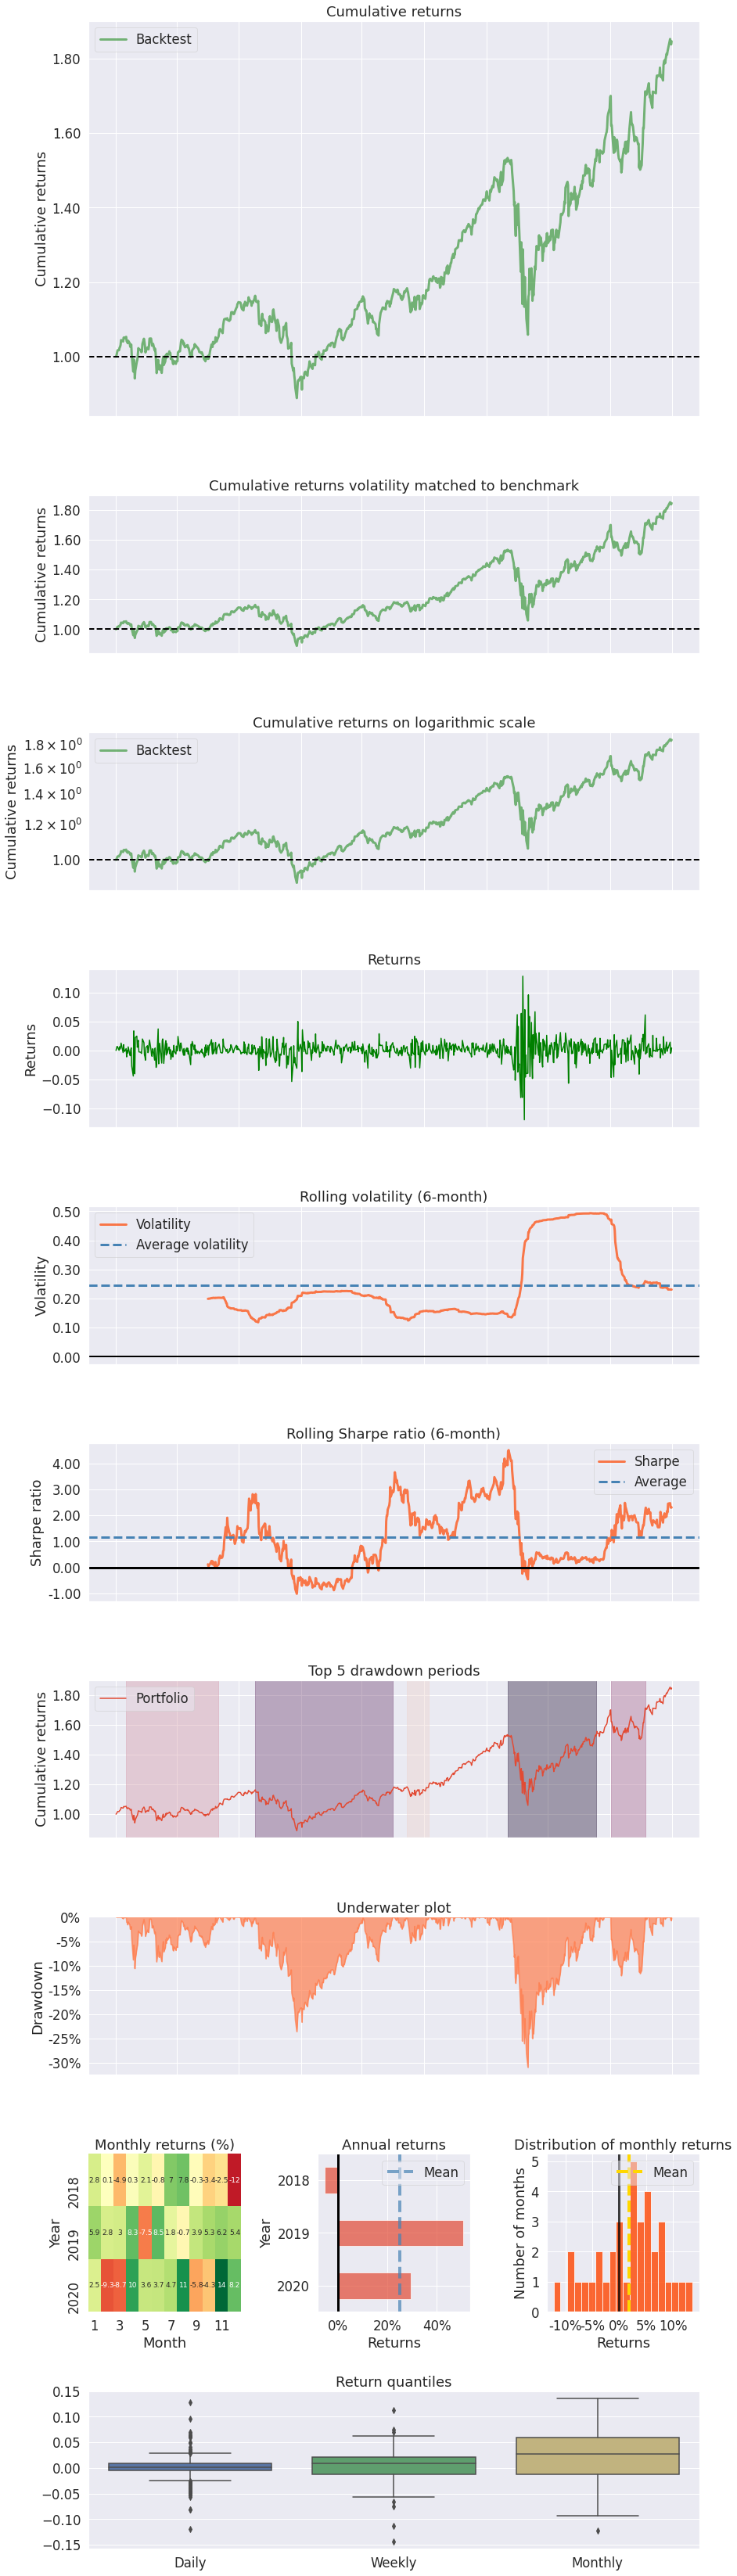

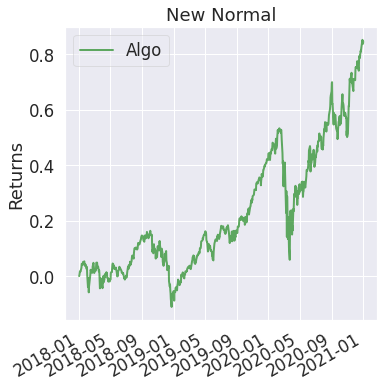

In [ ]:
## Backtest

dir(pyfolio)
backtest_a2c = df_daily_return_trade_a2c['daily_return']
backtest_a2c.index = df_daily_return_trade_a2c['Date']
pyfolio.create_full_tear_sheet(backtest_a2c)


# Performance DDGP Agent

In [ ]:
# DDPG agent

DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}

# Define dimension and state_space
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension
print('asset_dimension: {}, state space: {}'.format(asset_dimension, state_space))

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 100,\
          'transactions_costs': 0.00, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension, 'turbulence_treshold': None }

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()
print("The type of the environment is: {}".format(type(train_env)))


# Initialize
agent_name = "ddpg"
agent = Agent(env = train_env)
model_ddpg = agent.load_model(model_name = agent_name, model_kwargs = DDPG_PARAMS)
train_model_ddpg = agent.train_model(model = model_ddpg, tb_log_name = agent_name, total_timesteps=100000)

asset_dimension: 5, state space: 5
The type of the environment is: <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
Using cpu device
Logging to tensorboard_log/a2c/a2c/ddpg_1
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 199.78859655680355
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.0182576105092076
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 176.96466197389228
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.8842559214557978
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 176.96466197389228
-------------------------

In [ ]:
## Predict on train dataset ##

train_gym_ddpg = asset_allocation_environment(df = train, **kwargs)
df_daily_return, df_actions = Agent.rl_predeiction(model=train_model_ddpg, env_input = train_gym_ddpg)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 176.96466197389228
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.8842559214557978
-------------------------------------------------------
end


In [ ]:
## Preditct on trade dataset ##

trade_gym_ddpg = asset_allocation_environment(df = trade, **kwargs)
df_daily_return, df_actions = Agent.rl_predeiction(model=train_model_ddpg, env_input = trade_gym_ddpg)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 116.96957202472022
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.1174510078378914
-------------------------------------------------------
end


# Performance TD3 Agent

In [ ]:
# TD3 agent

TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}

# Define dimension and state_space
asset_dimension = train.tic.unique().shape[0]
state_space = asset_dimension
print('asset_dimension: {}, state space: {}'.format(asset_dimension, state_space))

# Define initial arguments for environment class - check indicator_list
kwargs = {'reward_scaling': 1e-1, 'max_assets': 100, 'initial_capital': 100,\
          'transactions_costs': 0.00, 'state_space': state_space, \
          'asset_dimension': asset_dimension,  'indicator_list' : indicator_list, \
          'action_space' : asset_dimension}

# Initialize environment
gym_enviroment_train =  asset_allocation_environment(df = train, **kwargs)
train_env, _ = gym_enviroment_train.get_sb_env()
print("The type of the environment is: {}".format(type(train_env)))


# Initialize
agent_name = "td3"
agent = Agent(env = train_env)
model_td3 = agent.load_model(model_name = agent_name, model_kwargs = TD3_PARAMS)
train_model_td3 = agent.train_model(model = model_td3, tb_log_name = agent_name, total_timesteps=100000)

asset_dimension: 4, state space: 4
The type of the environment is: <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
Using cpu device
Logging to tensorboard_log/a2c/a2c/td3_2
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 358.755311071471
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.226984940024841
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 349.8213223531466
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.1170785454476486
-------------------------------------------------------
-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 355.5523533349131
-------------------------------

In [ ]:
## Predict on train dataset ##

train_gym_td3 = asset_allocation_environment(df = train, **kwargs)
df_daily_return_td3_train, df_actions_td3_train = Agent.rl_predeiction(model=train_model_td3, env_input = train_gym_td3)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 356.4797167173344
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 1.1240932913713626
-------------------------------------------------------
end


In [ ]:
## Predict on trade dataset ##

trade_gym_td3 = asset_allocation_environment(df = trade, **kwargs)
df_daily_return_td3_trade, df_actions_tde_trade = Agent.rl_predeiction(model=train_model_td3, env_input = trade_gym_td3)

-------------------------------------------------------
Total beginning capital: 100
Total ending capital: 198.90289362192306
-------------------------------------------------------
-------------------------------------------------------
Sharpe Ratio: 0.9708513252622861
-------------------------------------------------------
end


Start date,2018-01-02
End date,2020-12-31
Total months,36
,Backtest
Annual return,25.761%
Cumulative returns,98.903%
Annual volatility,27.522%
Sharpe ratio,0.97
Calmar ratio,0.77
Stability,0.88
Max drawdown,-33.364%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.36,2020-02-10,2020-03-23,2020-08-12,133
1,20.16,2018-09-20,2018-12-24,2019-04-12,147
2,11.33,2020-09-02,2020-09-23,2020-11-09,49
3,9.19,2018-01-26,2018-02-08,2018-02-26,22
4,8.95,2018-03-09,2018-03-23,2018-06-06,64


Stress Events,mean,min,max
New Normal,0.11%,-13.30%,14.34%


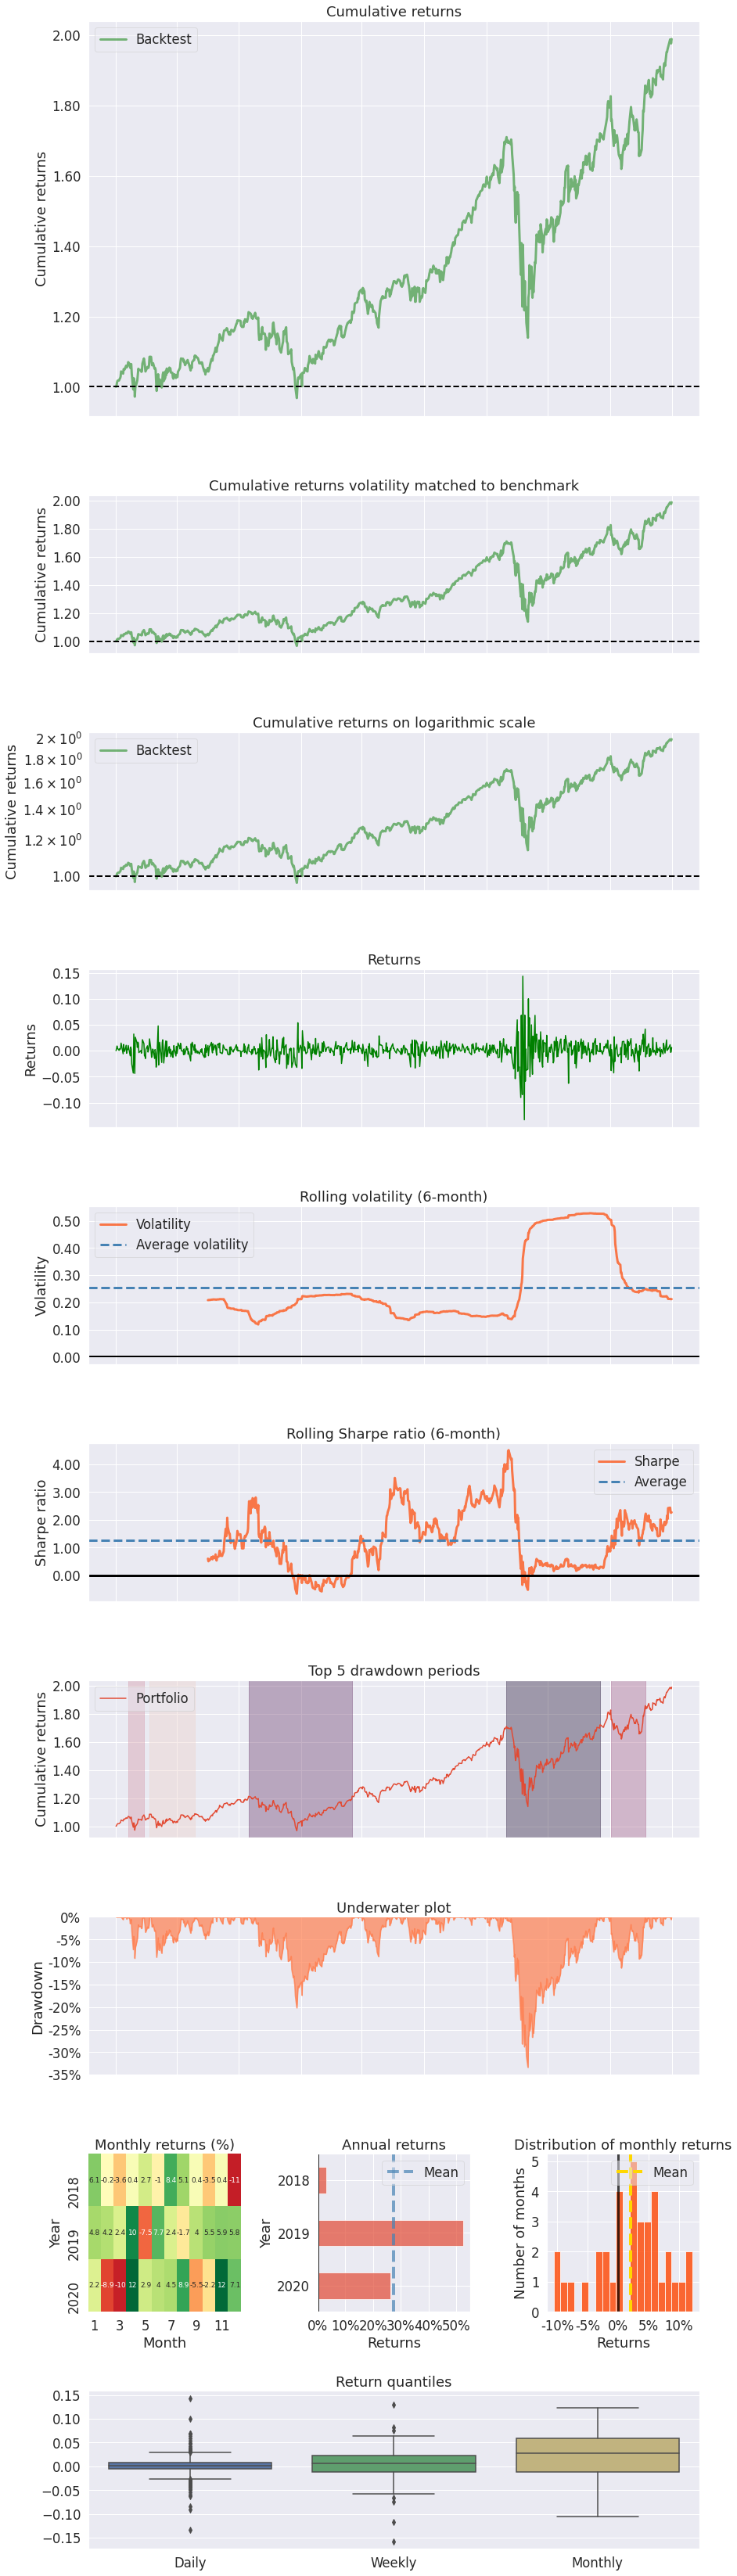

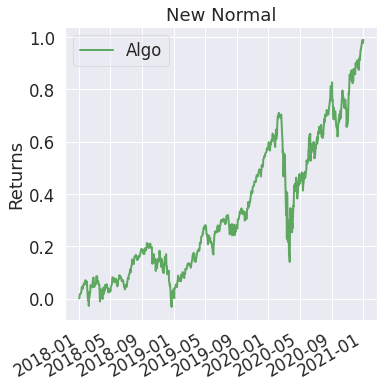

In [ ]:
## Backtest

backtest_td3 = df_daily_return_td3_trade['daily_return']
backtest_td3.index = df_daily_return_td3_trade['Date']
pyfolio.create_full_tear_sheet(backtest_td3)

# Performance SAC Agent

# Performance PPO Agent

# Performance of EW portfolios

In [ ]:
# Compare with EW portfolio on train
tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'DIS']

weights_ = [1/len(tickers) for i in tickers]

df1 = train[train.tic == 'AAPL'].Close.pct_change()
df2 = train[train.tic == 'MSFT'].Close.pct_change()
df3 = train[train.tic == 'JNJ'].Close.pct_change()
df4 = train[train.tic == 'JPM'].Close.pct_change()
df5 = train[train.tic == 'DIS'].Close.pct_change()

df_merge_trade = pd.concat([df1, df2, df3, df4, df5],axis=1)

returns = []
returns_for_cumprod = [100]

for i in range(1, len(df_merge_trade)):
  temp_ret = df_merge_trade.iloc[i,:].values * weights_
  temp_ret = sum(temp_ret)
  returns.append(temp_ret)
  returns_for_cumprod.append(1+temp_ret)

cumulative_ret = np.array(returns_for_cumprod).cumprod()

print("EW portfolio:")
print("Beginning capital: {}, Ending Capital: {}".format(cumulative_ret[0], cumulative_ret[-1]))
print("Sharpe ratio: {}".format(np.sqrt(252) * np.mean(returns)/np.std(returns)))


EW portfolio:
Beginning capital: 100.0, Ending Capital: 187.6623478773796
Sharpe ratio: 0.9461017340948049


In [ ]:
# Compare with EW portfolio on trade
tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'DIS']

weights_ = [1/len(tickers) for i in tickers]

df1 = trade[trade.tic == 'AAPL'].Close.pct_change()
df2 = trade[trade.tic == 'MSFT'].Close.pct_change()
df3 = trade[trade.tic == 'JNJ'].Close.pct_change()
df4 = trade[trade.tic == 'JPM'].Close.pct_change()
df5 = trade[trade.tic == 'DIS'].Close.pct_change()

df_merge_trade = pd.concat([df1, df2, df3, df4, df5],axis=1)

returns = []
returns_for_cumprod = [100]

for i in range(1, len(df_merge_trade)):
  temp_ret = df_merge_trade.iloc[i,:].values * weights_
  temp_ret = sum(temp_ret)
  returns.append(temp_ret)
  returns_for_cumprod.append(1+temp_ret)

cumulative_ret_ew_trade = np.array(returns_for_cumprod).cumprod()

print("EW portfolio:")
print("Beginning capital: {}, Ending Capital: {}".format(cumulative_ret_ew_trade[0], cumulative_ret_ew_trade[-1]))
print("Sharpe ratio: {}".format(np.sqrt(252) * np.mean(returns)/np.std(returns)))


EW portfolio:
Beginning capital: 100.0, Ending Capital: 143.27591176181767
Sharpe ratio: 0.7265791322855201


Start date,2010-01-04
End date,2012-12-31
Total months,35
,Backtest
Annual return,18.726%
Cumulative returns,67.125%
Annual volatility,19.83%
Sharpe ratio,0.97
Calmar ratio,1.07
Stability,0.88
Max drawdown,-17.571%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.57,2011-07-26,2011-10-03,2012-01-05,118
1,13.94,2010-04-23,2010-08-26,2010-10-28,135
2,13.43,2012-09-19,2012-11-15,NaT,NaN
3,9.84,2011-02-16,2011-06-24,2011-07-21,112
4,9.53,2012-04-02,2012-05-18,2012-07-17,77


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.13%,-5.70%,5.08%
Fukushima,-0.05%,-2.89%,1.58%
EZB IR Event,-0.09%,-1.33%,1.84%
Flash Crash,-0.52%,-3.61%,5.21%
Recovery,0.08%,-5.70%,5.21%


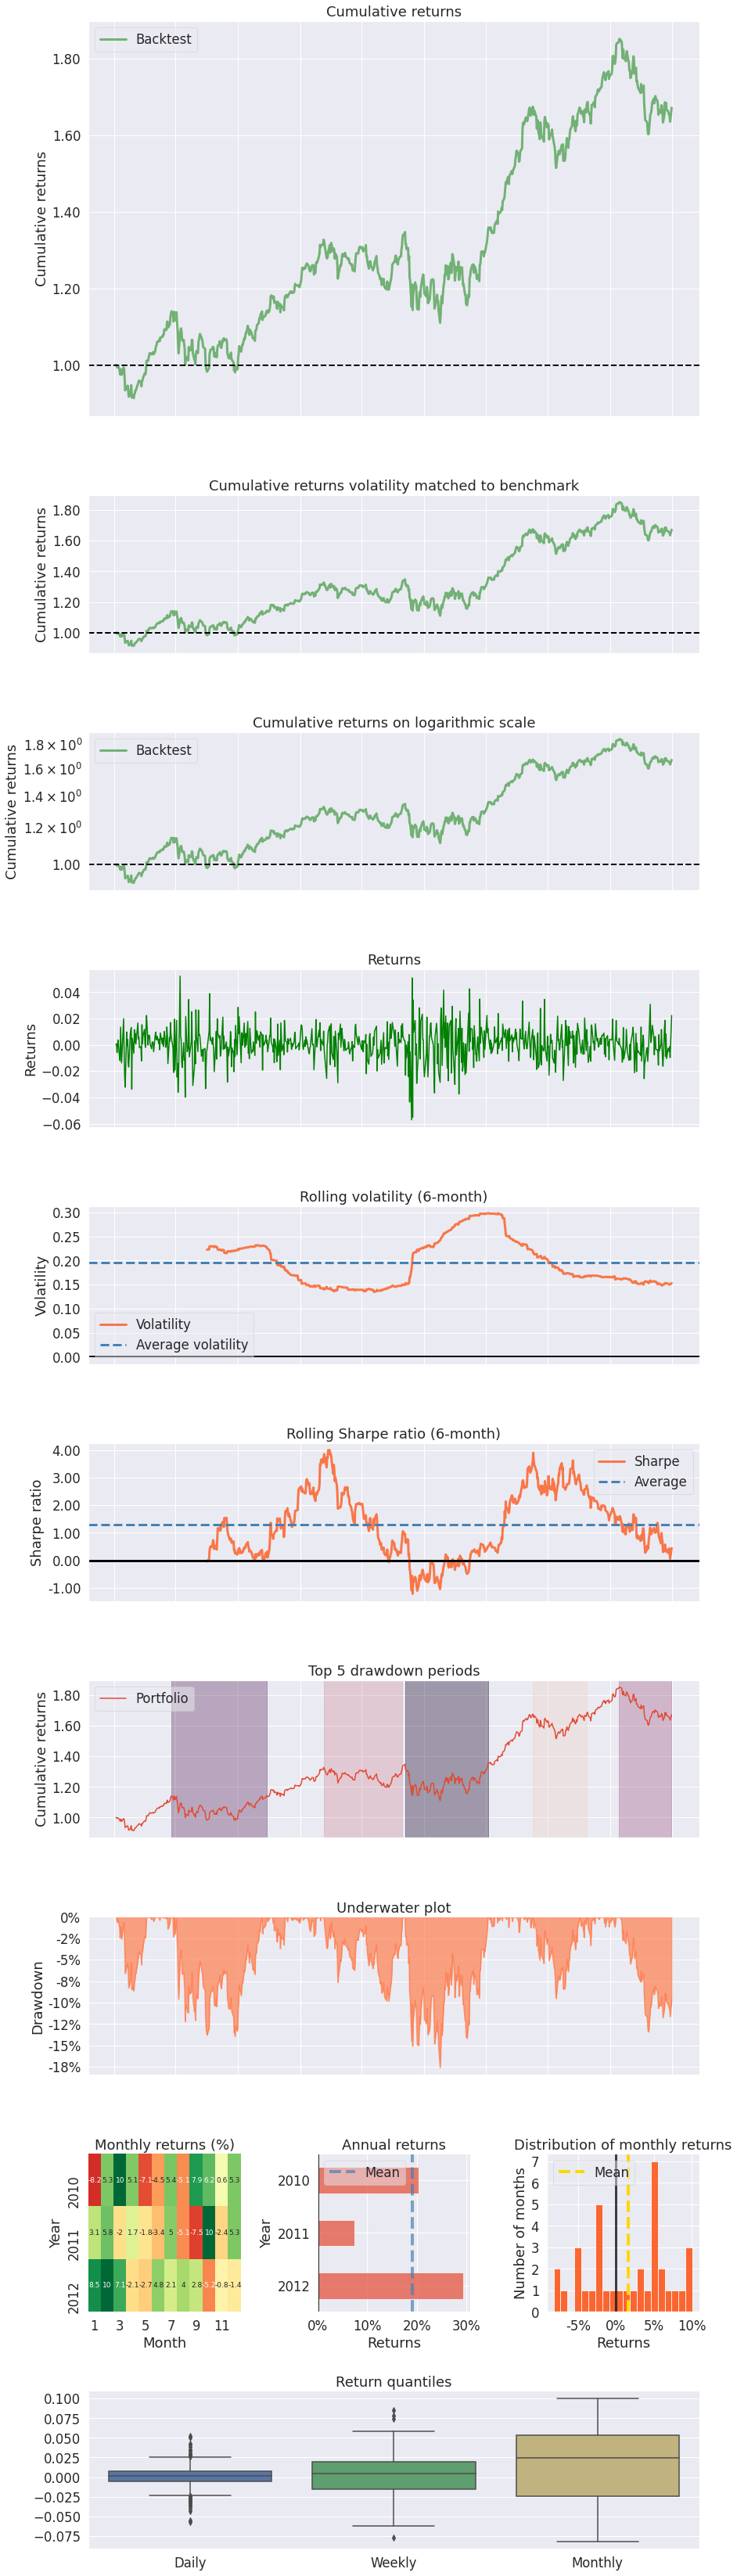

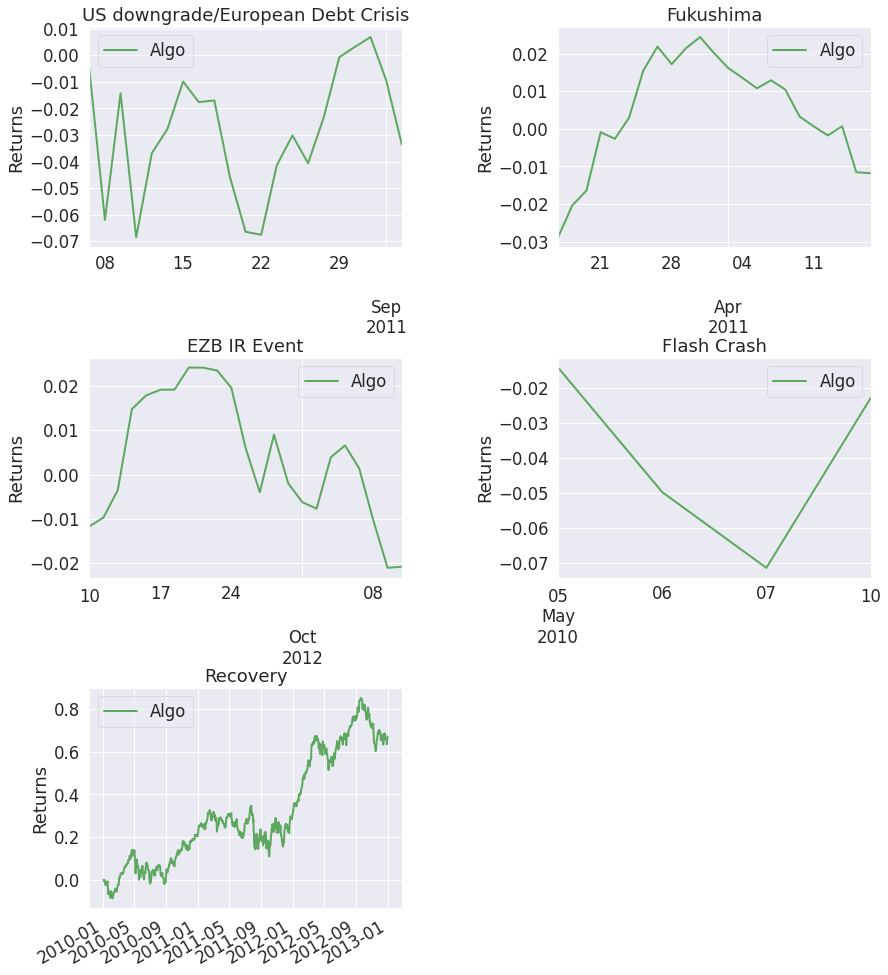

In [ ]:
## Backtest

backtest_ew = pd.DataFrame(returns)
backtest_ew.index = df_daily_return_td3_trade['Date'][1:]
pyfolio.create_full_tear_sheet(backtest_td3)

# Differential Sharpe Ratio

2.544836229832489

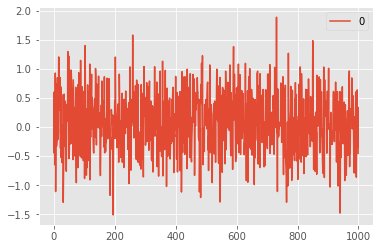

In [ ]:
import numpy as np

# Define array of random daily returns

np.random.seed(123)
ret = pd.DataFrame(np.random.normal(0.1,0.5,1000))




# Define Sharpe Ratio function
def sharpe_ratio(ret):
  ''' Numpry array as input '''
  ret = ret.values
  sharpe = np.sqrt(252)* ret.mean() / ret.std()
  return sharpe


'''

def sharpe(ls):
    return np.mean(ls)/np.std(ls)

# ls1 contains the true SR values
ls1 = []
sr0 = sharpe(pct[:200])
for i in range(500):
    sr = sharpe(pct[:200+i+1])
    ls1.append(sr-sr0)
    sr0 = sr

# ls2 uses cumulated DSR to approximate SR 
ls2 = []
eta = 0.004
# use the first 200 days to set an initial value of SR
sr = sharpe(pct[:200]) 
for i in range(500):
    A = np.mean(pct[:200+i])
    B = np.mean(pct[:200+i]**2)
    delta_A = pct[200+i+1] - A
    delta_B = pct[200+i+1]**2 - B
    Dt = (B*delta_A - 0.5*A*delta_B) / (B-A**2)**(3/2)
    sr += eta * Dt
    ls2.append(Dt*eta)
'''
ret.plot()
type(ret.values)
sharpe_ratio(ret)

# Parametersret.

In [ ]:
## Model Parameters
'''
MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}


A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
}
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}
SAC_PARAMS = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "batch_size": 64,
    "ent_coef": "auto_0.1",
}

# Define the params - see:
# https://github.com/AI4Finance-LLC/FinRL-Library/blob/master/finrl/config/config.py

## Just to see the names: "a2c", , "ddpg", "td3", "sac", "ppo"

#indicator_list = ['macd', 'dx_30', 'close_30_sma']


indicator_list = ['volume_delta','open_2_d','open_-2_r','close_30_sma', 'close_60_sma','cr','cr-ma1','cr-ma2','cr-ma3','kdjk' \
      ,'kdjd', 'kdjj', 'open_2_sma', 'macd', 'macds', 'boll', 'boll_ub', 'boll_lb'\
      ,'rsi_6', 'rsi_12', 'rsi_30', 'wr_10', 'wr_6', 'cci', 'cci_20',  'cci_30', 'tr' \
      ,'atr', 'dma', 'pdi', 'mdi', 'dx','dx_30', 'adx', 'adxr', 'trix', 'close_3_trix', 'trix_9_sma', 'tema' \
      , 'close_2_tema', 'vr', 'vr_6_sma']
      
#tickers = ['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']

'''


'''



In [ ]:
# Important configrations
# Imported from http://pypi.org/project/stockstats
'''
indicator_list = ['macd', 'boll_lb', 'boll-lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
'''
# Implementation of the stockstats indicators
'''
stock = yf.download('AAPL', start_date, end_date)
stock = Sdf.retype(stock)
stock['open_2_sma']
'''

"\nstock = yf.download('AAPL', start_date, end_date)\nstock = Sdf.retype(stock)\nstock['open_2_sma']\n"

In [ ]:
# Resampling from daily to montly
'''
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.resample('1M').mean()
'''

# Deterministic Asset Price Simulation

In [ ]:
### test

# Stochastic Asset Price Simulation

In [ ]:
## Simulate stochastic asset prices with known characteristics in terms of drift and vol
## THEORY FROM HULL TEXTBOOK

## Simulate Geometric Brownian Motion

def brownian_motion(initial, drift, vol, innovation):
  return initial*np.exp()

In [ ]:
np.seed = 123
innovations = np.random.normal(0,1,100).tolist()

drift = 0.1
vol = 0.2

bm = []

# Economic Macro Data

In [3]:
'''
Growth:
GDP - Gross Domestic Product
GDPC1 - Real Gross Domestic Product
GDPPOT - Real Potential Gross Domestic Product

Inflation:
CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items
CPILFESL- Consumer Price Index for All Urban Consumers: All Items Less Food & Energy
GDPDEF - Gross Domestic Product: Implicit Price Deflator\n",

Money Supply:
BASE - St. Louis Adjusted Monetary Base
M1 - M1 Money Stock
M2 - M2 Money Stock
M1V - Velocity of M1 Money Stock
M2V - Velocity of M2 Money Stock

Interest Rates:
DFF - Effective Federal Funds Rate
DTB3 - 3-Month Treasury Bill: Secondary Market Rate
DGS5 - 5-Year Treasury Constant Maturity Rate
DGS10 - 10-Year Treasury Constant Maturity Rate
DGS30 - 30-Year Treasury Constant Maturity Rate
T5YIE - 5-year Breakeven Inflation Rate
T10YIE - 10-year Breakeven Inflation Rate
T5YIFR - 5-Year, 5-Year Forward Inflation Expectation Rate
TEDRATE - TED Spread
DPRIME - Bank Prime Loan Rate

Employment:
UNRATE - Civilian Unemployment Rate
NROU - Natural Rate of Unemployment (Long-Term)
NROUST - Natural Rate of Unemployment (Short-Term)
CIVPART - Civilian Labor Force Participation Rate
EMRATIO - Civilian Employment-Population Ratio
UNEMPLOY - Unemployed
PAYEMS - All Employees: Total nonfarm
MANEMP - All Employees: Manufacturing
ICSA - Initial Claims
IC4WSA - 4-Week Moving Average of Initial Claims

Income and expenditure:
MEHOINUSA672N - Real Median Household Income in the United States
DSPIC96 - Real Disposable Personal Income
PCE - Personal Consumption Expenditures
PCEDG - Personal Consumption Expenditures: Durable Goods
PSAVERT - Personal Saving Rate
RRSFS - Real Retail and Food Services Sales
DSPI - Disposable personal income

Other Economic Indicators:
INDPRO - Industrial Production Index
TCU - Capacity Utilization: Total Industry
HOUST - Housing Starts: Total: New Privately Owned Housing Units Started
GPDI - Gross Private Domestic Investment
CP - Corporate Profits After Tax (without IVA and CCAdj)
STLFSI - St. Louis Fed Financial Stress Index
DCOILWTICO - Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
USSLIND - Leading Index for the United States
DTWEXM - Trade Weighted U.S. Dollar Index: Major Currencies
DTWEXB - Trade Weighted U.S. Dollar Index: Broad
VIXCLS - Market expectation of near term volatility conveyed by stock index option prices

Debt:
GFDEBTN - Federal Debt: Total Public Debt
GFDEGDQ188S - Federal Debt: Total Public Debt as Percent of Gross Domestic Product
EXCSRESNW - Excess Reserves of Depository Institutions
TOTCI - Commercial and Industrial Loans, All Commercial Banks

New indicators:
USALORSGPNOSTSAM - Leading Indicators OECD: Reference series: Gross Domestic Product (GDP): Normalised for the United States
GEPUCURRENT - Global Economic Policy Uncertainty Index: Current Price Adjusted GDP
CHNLORSGPNOSTSAM - Leading Indicators OECD: Reference series: Gross Domestic Product (GDP): Normalised for China

Currency:
DEXUSEU - USDEUR exchange rate

'''

## Some lists with variables
growth = ['GDP', 'GDPC1', 'GDPPOT']
inflation = ['CPIAUCSL', 'CPILFESL', 'GDPDEF']
money_supply = ['BASE', 'M1', 'M2', 'M1V', 'M2V']
interest_rates = ['DFF', 'DTB3', 'DGS5', 'DGS10', 'DGS30', 'T5YIE', 'T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME' ]
employment = ['UNRATE', 'NROU', 'NROUST', 'CIVPART', 'EMRATIO', 'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA']
income_expend = ['MEHOINUSA672N', 'DSPIC96', 'PCE', 'PCEDG', 'PSAVERT', 'RRSFS', 'DSPI']
other_indicators = ['INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI', 'DCOILWTICO', 'USSLIND', 'DTWEXM', 'DTWEXB']
debt = ['GFDEBTN', 'GFDEGDQ188S', 'EXCSRESNW', 'TOTCI']

In [34]:
#vix = pdata.DataReader(name= 'VIXCLS', data_source = 'fred')

## Data that can be applied:
'''
inflation[0] - monthly
money_supply[1] - weekly
money_supply[2] - weekly
interest_rates[0]
interest_rates[1]
interest_rates[2]
interest_rates[3]
interest_rates[4]
'''

start = dt.datetime(1990,1,1)
end = dt.datetime(2021,3,10)

# Data extraction check
name = employment[3]

econ_df = pdata.DataReader(name= name, data_source = 'fred', start = start, end = end)
econ_df = econ_df.iloc[::-1]
econ_df

,CIVPART
DATE,
2021-02-01,61.4
2021-01-01,61.4
2020-12-01,61.5
2020-11-01,61.5
2020-10-01,61.6
...,...
1990-05-01,66.6
1990-04-01,66.6
1990-03-01,66.7
